In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

# Load rossmann store data



In [3]:
#access files in my Google Drive to read in file correctly
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data Loading
# Source: https://www.kaggle.com/competitions/rossmann-store-sales/data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rossmann-store-sales/train.csv', parse_dates=['Date'])
store = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rossmann-store-sales/store.csv')
df = pd.merge(train, store, on='Store', how='left')

In [5]:
#select 20% store samples randomly
sample_stores = np.random.choice(df['Store'].unique(), size=int(0.2 * len(df['Store'].unique())), replace=False)
df = df[df['Store'].isin(sample_stores)]
print(f"Sampled dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

df.info()
df.head()

Sampled dataset shape: (203810, 18)
Date range: 2013-01-01 to 2015-07-31
<class 'pandas.core.frame.DataFrame'>
Index: 203810 entries, 19 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      203810 non-null  int64         
 1   DayOfWeek                  203810 non-null  int64         
 2   Date                       203810 non-null  datetime64[ns]
 3   Sales                      203810 non-null  int64         
 4   Customers                  203810 non-null  int64         
 5   Open                       203810 non-null  int64         
 6   Promo                      203810 non-null  int64         
 7   StateHoliday               203810 non-null  object        
 8   SchoolHoliday              203810 non-null  int64         
 9   StoreType                  203810 non-null  object        
 10  Assortment                 203810 non-null  ob

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
19,20,5,2015-07-31,9593,974,1,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
27,28,5,2015-07-31,7301,663,1,1,0,1,a,a,1200.0,10.0,2014.0,1,6.0,2015.0,"Mar,Jun,Sept,Dec"
31,32,5,2015-07-31,6395,635,1,1,0,0,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
34,35,5,2015-07-31,12412,777,1,1,0,1,d,c,7660.0,10.0,2000.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
37,38,5,2015-07-31,7434,608,1,1,0,1,d,a,1090.0,4.0,2007.0,0,NaN,NaN,NaN


# Data cleaning and fill NaN

In [6]:
df = df[df['Open'] == 1].reset_index(drop=True)
df.drop(['Open', 'PromoInterval'], axis=1, inplace=True, errors='ignore')
df = df[df['Sales'] > 0]
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df['CompetitionOpenMissing'] = df['CompetitionOpenSinceMonth'].isna().astype('int8')
df['CompetitionOpenSinceMonth'].fillna(df['CompetitionOpenSinceMonth'].median(), inplace=True)
df['CompetitionOpenSinceYear'].fillna(df['CompetitionOpenSinceYear'].median(), inplace=True)

In [7]:
df.fillna(0, inplace=True)

print(f"Cleaned dataset shape: {df.shape}")
print("\nSummary statistics:")
print(df.describe())
print("\nCategorical feature value counts:")
for col in ['StoreType', 'Assortment']:
    print(f"\n{col}:\n{df[col].value_counts()}")

Cleaned dataset shape: (169494, 17)

Summary statistics:
               Store      DayOfWeek                           Date  \
count  169494.000000  169494.000000                         169494   
mean      554.861157       3.523322  2014-04-11 06:07:41.071188224   
min        20.000000       1.000000            2013-01-01 00:00:00   
25%       308.000000       2.000000            2013-08-17 00:00:00   
50%       535.000000       3.000000            2014-04-01 00:00:00   
75%       805.000000       5.000000            2014-12-10 00:00:00   
max      1115.000000       7.000000            2015-07-31 00:00:00   
std       303.355636       1.726196                            NaN   

               Sales      Customers          Promo  SchoolHoliday  \
count  169494.000000  169494.000000  169494.000000  169494.000000   
mean     7076.506118     789.536172       0.445951       0.192650   
min       541.000000      78.000000       0.000000       0.000000   
25%      4821.000000     507.000000 

In [8]:
# Outlier Handling
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Sales'] = np.where(df['Sales'] > upper_bound, upper_bound, np.where(df['Sales'] < lower_bound, lower_bound, df['Sales']))

# Perform EDA

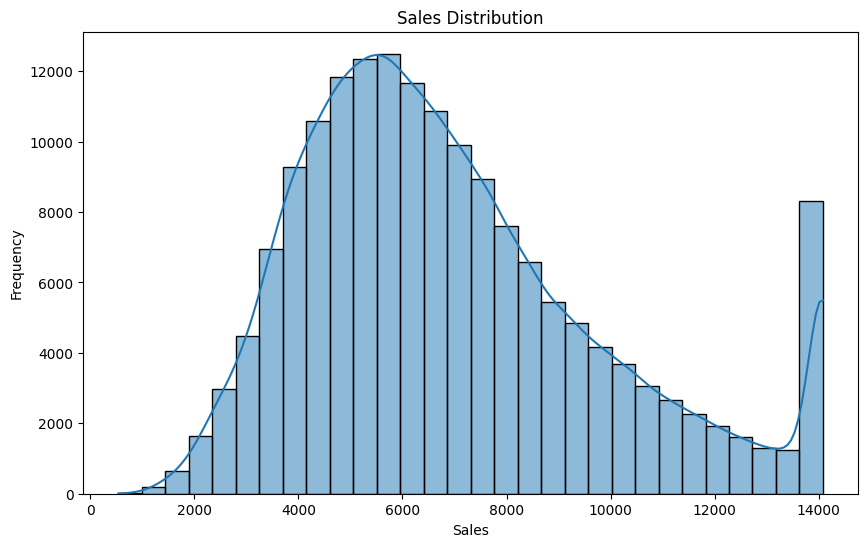

In [9]:
#  Sales distribution histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=30, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

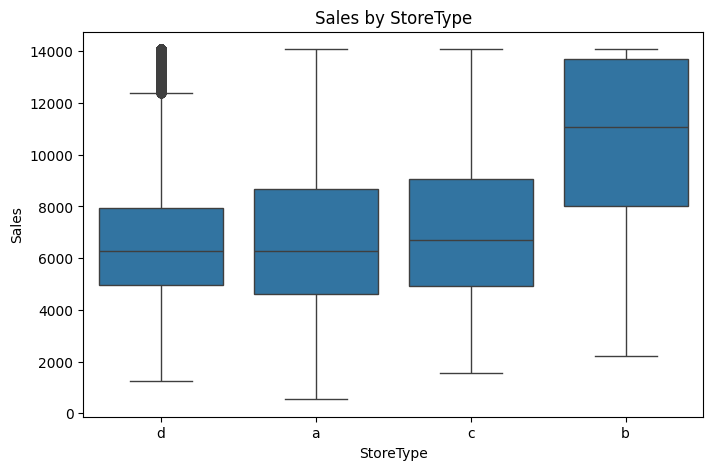

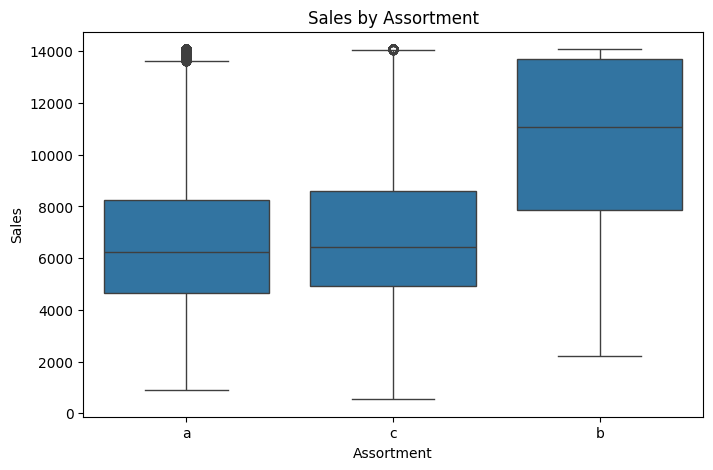

In [10]:
# Sales by categorical features
for col in ['StoreType', 'Assortment']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=col, y='Sales', data=df)
    plt.title(f'Sales by {col}')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.show()

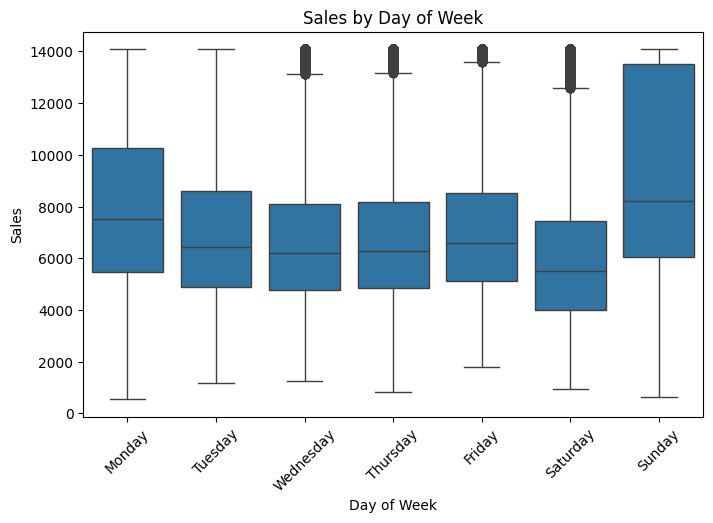

In [11]:
#Plot Sales by DayOfWeek
plt.figure(figsize=(8, 5))
sns.boxplot(x='DayOfWeek', y='Sales', data=df)
plt.title('Sales by Day of Week')
# Map numeric days (1-7) to weekday names
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
plt.xticks(ticks=range(7), labels=[day_names[i+1] for i in range(7)], rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.show()

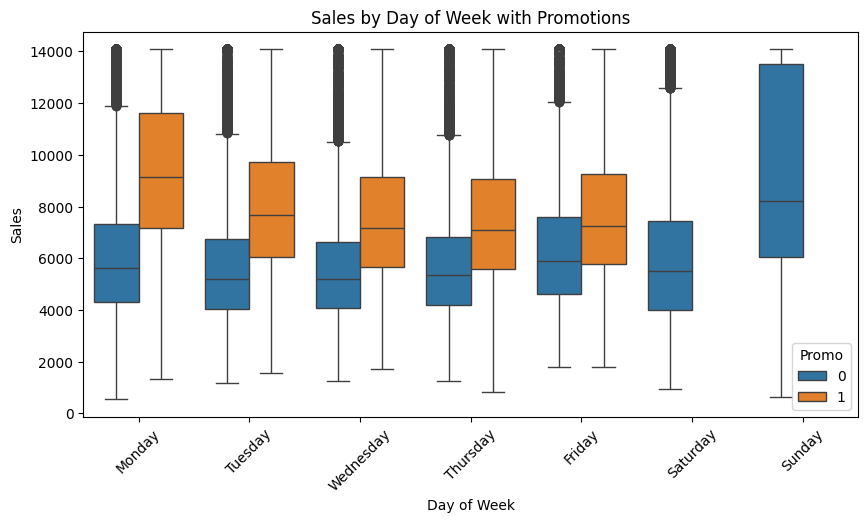

In [12]:
#how promotions affect daily sales
plt.figure(figsize=(10, 5))
sns.boxplot(x='DayOfWeek', y='Sales', hue='Promo', data=df)
plt.title('Sales by Day of Week with Promotions')
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
plt.xticks(ticks=range(7), labels=[day_names[i+1] for i in range(7)], rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.show()

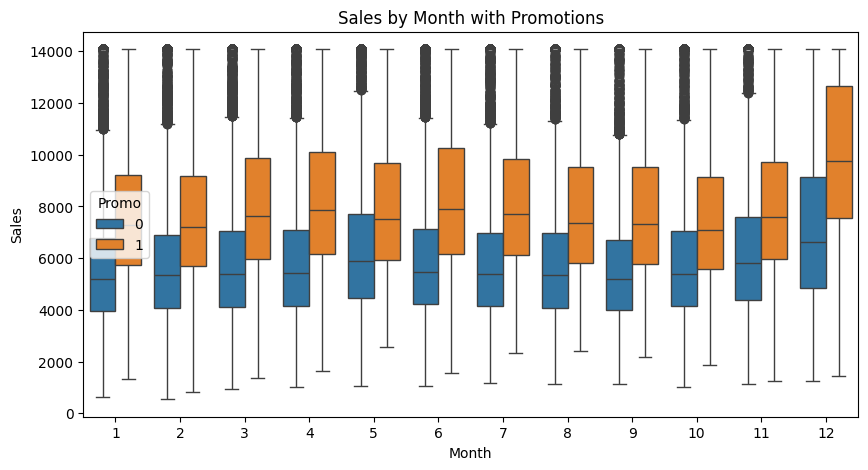

In [15]:
#how promotions affect seasonal sales
df['Month'] = df['Date'].dt.month
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='Sales', hue='Promo', data=df)
plt.title('Sales by Month with Promotions')
#plt.xticks(ticks=range(7), labels=[day_names[i+1] for i in range(7)], rotation=45)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

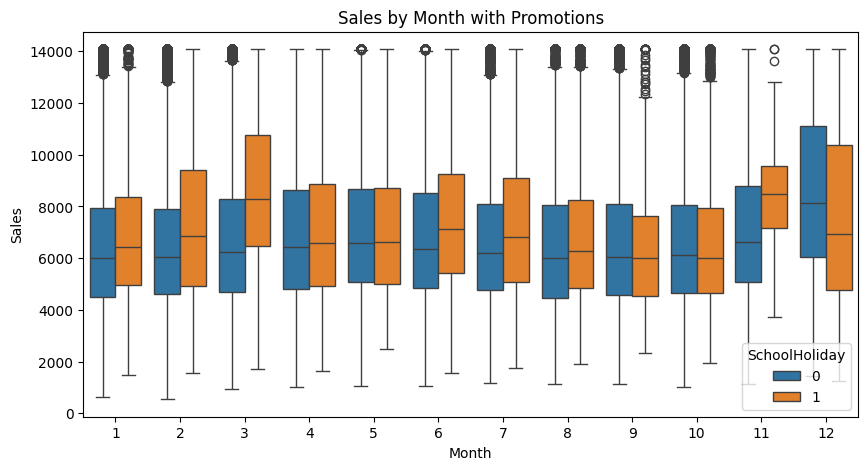

In [16]:
#how promotions and school holiday affect sales
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='Sales', hue='SchoolHoliday', data=df)
plt.title('Sales by Month with Promotions')
#plt.xticks(ticks=range(7), labels=[day_names[i+1] for i in range(7)], rotation=45)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

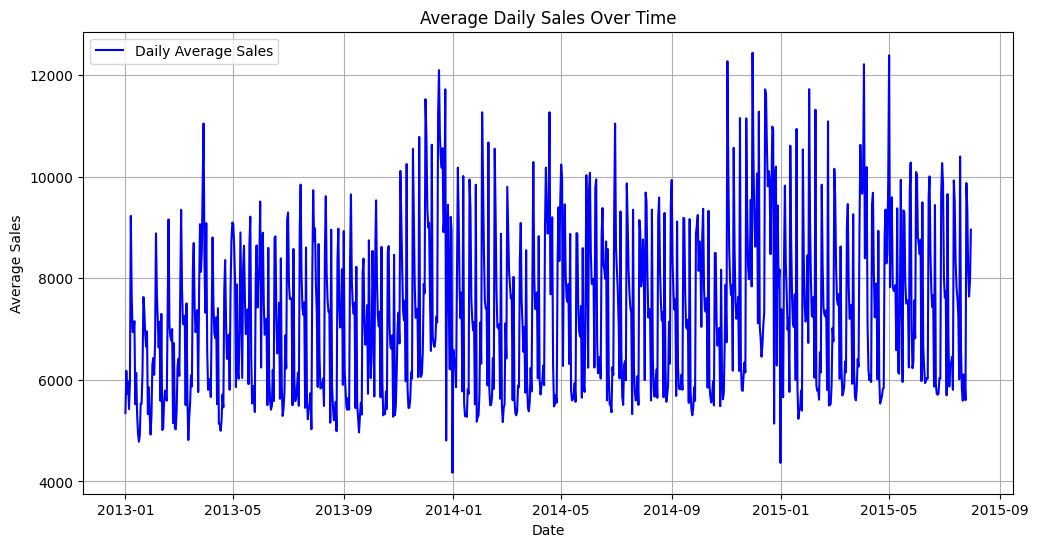

In [17]:
#Sales Over Time
plt.figure(figsize=(12, 6))
# Compute daily average sales
daily_sales = df.groupby('Date')['Sales'].mean().reset_index()
plt.plot(daily_sales['Date'], daily_sales['Sales'], color='blue', label='Daily Average Sales')
plt.title('Average Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.show()

Top 12 Features Correlated with Sales:
                       Feature  Correlation with Sales
1                   Customers                0.781254
2                       Promo                0.355791
3                      Promo2               -0.207011
4             Promo2SinceYear               -0.207006
5             Promo2SinceWeek               -0.155497
6                   DayOfWeek               -0.154137
7      CompetitionOpenMissing               -0.103108
8         CompetitionDistance               -0.100101
9    CompetitionOpenSinceYear                0.047682
10              SchoolHoliday                0.038138
11                      Store                0.033464
12  CompetitionOpenSinceMonth                0.004894


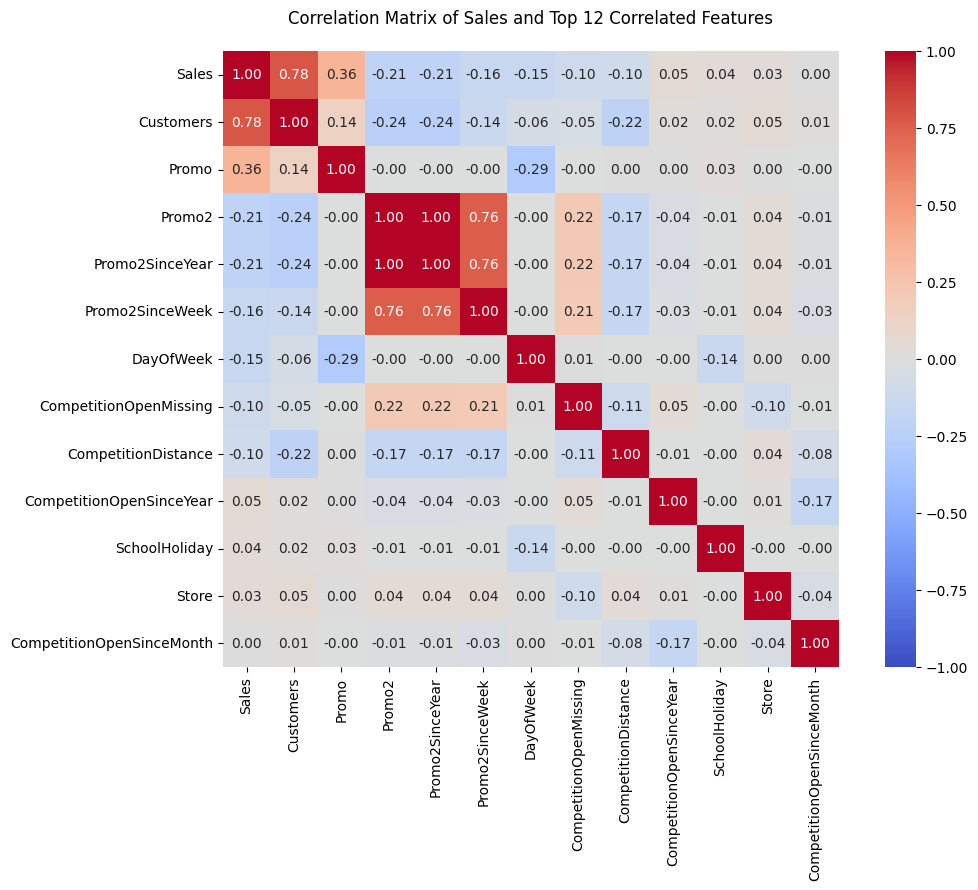

In [14]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=np.number).columns
df_numeric = df[numeric_cols]
corr_matrix = df_numeric.corr()
sales_corr = corr_matrix['Sales'].drop('Sales')
top_12_features = sales_corr.abs().sort_values(ascending=False).head(12)
top_12_df = pd.DataFrame({
    'Feature': top_12_features.index,
    'Correlation with Sales': sales_corr[top_12_features.index]
}).reset_index(drop=True)
top_12_df.index += 1
print("Top 12 Features Correlated with Sales:\n", top_12_df)

cols_to_plot = ['Sales'] + top_12_features.index.tolist()
cols_to_plot = [col for col in cols_to_plot if col in corr_matrix.columns]
filtered_corr_matrix = corr_matrix.loc[cols_to_plot, cols_to_plot]
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)
plt.title("Correlation Matrix of Sales and Top 12 Correlated Features", pad=20)
plt.savefig('corr_matrix_top12.png', dpi=300, bbox_inches='tight')
plt.show()

# Adcanced feature engineering

In [18]:
# Data Loading
# Source: https://www.kaggle.com/competitions/rossmann-store-sales/data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rossmann-store-sales/train.csv', parse_dates=['Date'])
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rossmann-store-sales/test.csv', parse_dates=['Date'])
### Setting a variable to easily distinguish train (1) from test (0) set
train['Set'] = 1
test['Set'] = 0
df = pd.concat([train, test], axis=0, ignore_index=True)
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)


In [19]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058297 entries, 0 to 1058296
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1058297 non-null  int64         
 1   DayOfWeek      1058297 non-null  int64         
 2   Date           1058297 non-null  datetime64[ns]
 3   Sales          1017209 non-null  float64       
 4   Customers      1017209 non-null  float64       
 5   Open           1058286 non-null  float64       
 6   Promo          1058297 non-null  int64         
 7   StateHoliday   1058297 non-null  object        
 8   SchoolHoliday  1058297 non-null  int64         
 9   Set            1058297 non-null  int64         
 10  Id             41088 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 88.8+ MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Set,Id
1058292,1115,7,2015-09-13,NaN,NaN,0.0,0,0,0,0,4280.0
1058293,1115,1,2015-09-14,NaN,NaN,1.0,1,0,0,0,3424.0
1058294,1115,2,2015-09-15,NaN,NaN,1.0,1,0,0,0,2568.0
1058295,1115,3,2015-09-16,NaN,NaN,1.0,1,0,0,0,1712.0
1058296,1115,4,2015-09-17,NaN,NaN,1.0,1,0,0,0,856.0


In [20]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [21]:
# Outlier Handling
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Sales'] = np.where(df['Sales'] > upper_bound, upper_bound, np.where(df['Sales'] < lower_bound, lower_bound, df['Sales']))

In [22]:
def add_rolling_stats(df, windows=[90, 180, 365]):
    for window in windows:
        grp = df.groupby("Store")["Sales"].shift(window)
        df[f"roll_mean_{window}"] = grp.rolling(window).mean()
        df[f"roll_mean_{window}"] = df[f"roll_mean_{window}"].fillna(df[f"roll_mean_{window}"].mean())
        df[f"roll_std_{window}"] = grp.rolling(window).std()
        df[f"roll_std_{window}"] = df[f"roll_std_{window}"].fillna(df[f"roll_std_{window}"].mean())
        df[f"roll_skew_{window}"] = grp.rolling(window).skew()
        df[f"roll_skew_{window}"] = df[f"roll_skew_{window}"].fillna(df[f"roll_skew_{window}"].mean())
        df[f"roll_kurt_{window}"] = grp.rolling(window).kurt()
        df[f"roll_kurt_{window}"] = df[f"roll_kurt_{window}"].fillna(df[f"roll_kurt_{window}"].mean())
    return df
df = add_rolling_stats(df)

In [23]:
def add_event_counters(df, col):
    df[f"days_since_{col}"] = df.groupby("Store")[col].apply(
        lambda s: s.groupby(s.cumsum()).cumcount()
    ).reset_index(level=0, drop=True)
    df[f"days_to_{col}"] = df.groupby("Store")[col].apply(
        lambda s: (s[::-1].groupby(s[::-1].cumsum()).cumcount()[::-1])
    ).reset_index(level=0, drop=True)
    return df
df = add_event_counters(df, "Promo")
df = add_event_counters(df, "SchoolHoliday")

In [24]:
def add_trend_features(df, periods=[90, 180, 365]):
    df["Serial"] = (df["Date"] - df["Date"].min()).dt.days
    for period in periods:
        df[f"slope_{period}"] = 0.0
        for store_id, group in df.groupby("Store"):
            recent = group.tail(period)
            if len(recent) < 10: continue
            X = recent[["Serial"]]
            y = recent[f"roll_mean_{period}"]
            reg = Ridge()
            reg.fit(X, y)
            df.loc[recent.index, f"slope_{period}"] = reg.coef_[0]
    return df
df = add_trend_features(df)

In [25]:
var_name = 'Date'

df[var_name + 'Day'] = df[var_name].dt.day #day of the month
df[var_name + 'Week'] = df[var_name].dt.isocalendar().week
df[var_name + 'Month'] = df[var_name].dt.month
df[var_name + 'Year'] = df[var_name].dt.year
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

df['DateInt'] = df['Date'].astype(np.int64)

In [26]:
def add_group_stats(df):
    df["group_mean_sales"] = df.groupby(["Store", "DayOfWeek", "DateMonth", "Promo"])["Sales"].transform("mean")
    return df
df = add_group_stats(df)

In [27]:
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [28]:
#convert sales to log
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales'])

In [29]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Set,...,slope_180,slope_365,DateDay,DateWeek,DateMonth,DateYear,DateDayOfYear,DateInt,group_mean_sales,SalesLog
1058292,1115,7,2015-09-13,NaN,NaN,0.0,0,1,0,0,...,3.603624,-1.626794,13,37,9,2015,256,1442102400000000000,0.00,NaN
1058293,1115,1,2015-09-14,NaN,NaN,1.0,1,1,0,0,...,3.603624,-1.626794,14,38,9,2015,257,1442188800000000000,7589.40,NaN
1058294,1115,2,2015-09-15,NaN,NaN,1.0,1,1,0,0,...,3.603624,-1.626794,15,38,9,2015,258,1442275200000000000,6524.20,NaN
1058295,1115,3,2015-09-16,NaN,NaN,1.0,1,1,0,0,...,3.603624,-1.626794,16,38,9,2015,259,1442361600000000000,6281.75,NaN
1058296,1115,4,2015-09-17,NaN,NaN,1.0,1,1,0,0,...,3.603624,-1.626794,17,38,9,2015,260,1442448000000000000,6306.00,NaN


In [30]:
#read in store data
df_store = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rossmann-store-sales/store.csv')

In [31]:
### Convert Storetype and Assortment to numerical categories
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [32]:
### Convert competition open year and month to float
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

df_store['CompetitionOpenInt'] = df_store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [33]:
### Convert competition open year and month to float
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

df_store['Promo2SinceFloat'] = df_store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [34]:
s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9,
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [35]:
df = pd.merge(df, df_store, how='left', on=['Store'])

In [36]:
df['Promo2'] = 0
df.loc[( (df['DateMonth'] == df['PromoInterval0']) | (df['DateMonth'] == df['PromoInterval1']) | (df['DateMonth'] == df['PromoInterval2']) | (df['DateMonth'] == df['PromoInterval3']) ), 'Promo2'] = 1

In [37]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Set', 'Id', 'roll_mean_90',
       'roll_std_90', 'roll_skew_90', 'roll_kurt_90', 'roll_mean_180',
       'roll_std_180', 'roll_skew_180', 'roll_kurt_180', 'roll_mean_365',
       'roll_std_365', 'roll_skew_365', 'roll_kurt_365', 'days_since_Promo',
       'days_to_Promo', 'days_since_SchoolHoliday', 'days_to_SchoolHoliday',
       'Serial', 'slope_90', 'slope_180', 'slope_365', 'DateDay', 'DateWeek',
       'DateMonth', 'DateYear', 'DateDayOfYear', 'DateInt', 'group_mean_sales',
       'SalesLog', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenInt', 'Promo2SinceFloat', 'PromoInterval0',
       'PromoInterval1', 'PromoInterval2', 'PromoInterval3'],
      dtype='object')

In [80]:
store_features = ['Store', 'StoreType', 'Assortment',
                  'CompetitionDistance', 'CompetitionOpenInt','Promo2']
features_x = ['Store', 'DateDay','DateWeek','DateMonth','DateYear','DateDayOfYear', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'StateHoliday', 'group_mean_sales',
       'roll_mean_90','roll_std_90', 'roll_skew_90', 'roll_kurt_90', 'slope_90',
       #'roll_mean_180','roll_std_180', 'roll_skew_180', 'roll_kurt_180', 'slope_180',
       #'roll_mean_365','roll_std_365', 'roll_skew_365', 'roll_kurt_365', 'slope_365',
       'days_since_Promo', 'days_to_Promo', 'days_since_SchoolHoliday','days_to_SchoolHoliday'
       ]
features_y = ['SalesLog']
### Features not helping
# PromoInterval1, PromoInterval2, PromoInterval3

features_x = list(set(features_x + store_features))

In [40]:
### Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

In [41]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Set,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2SinceFloat,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
0,1,2,2013-01-01,0.0,0.0,0.0,0,2,1,1,...,0,NaN,NaN,NaN,1220227200000000000,-9223372036854775808,NaN,NaN,NaN,NaN
1,1,3,2013-01-02,5530.0,668.0,1.0,0,1,1,1,...,0,NaN,NaN,NaN,1220227200000000000,-9223372036854775808,NaN,NaN,NaN,NaN
2,1,4,2013-01-03,4327.0,578.0,1.0,0,1,1,1,...,0,NaN,NaN,NaN,1220227200000000000,-9223372036854775808,NaN,NaN,NaN,NaN
3,1,5,2013-01-04,4486.0,619.0,1.0,0,1,1,1,...,0,NaN,NaN,NaN,1220227200000000000,-9223372036854775808,NaN,NaN,NaN,NaN
4,1,6,2013-01-05,4997.0,635.0,1.0,0,1,1,1,...,0,NaN,NaN,NaN,1220227200000000000,-9223372036854775808,NaN,NaN,NaN,NaN


In [42]:
### Get total sales, customers and open days per store
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()
### Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day
df_store = pd.merge(df_store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])


In [81]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']
features_x = list(set(features_x + store_features))

In [44]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])
df_encoded = df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Sales'] > 0)]

In [82]:
X = df_encoded[features_x]
y = df_encoded[features_y]
feature_names = X.columns  # Store feature names for importance plots

In [83]:
len(feature_names)

28

# Train the model

In [47]:
def rmspe(y_true, y_pred):
    """
    Calculates the Root Mean Square Percentage Error.

    Args:
        y_true (array-like): The ground truth values.
        y_pred (array-like): The predicted values.

    Returns:
        float: The RMSPE score.
    """
    # Ensure there are no zero values in y_true to avoid division by zero
    # We add a very small number (epsilon) to the denominator.
    epsilon = 1e-10

    # Calculate the percentage error
    percentage_error = (y_true - y_pred) / (y_true + epsilon)

    # Square the percentage errors, take the mean, and then the square root
    rmspe_score = np.sqrt(np.mean(np.square(percentage_error)))

    return rmspe_score

In [84]:
# Time-based split
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)
X_train = X.iloc[:train_size]
X_val = X.iloc[train_size:train_size + val_size]
X_test = X.iloc[train_size + val_size:]
y_train = y.iloc[:train_size]; y_train_arr = np.asarray(y_train['SalesLog'])
y_val = y.iloc[train_size:train_size + val_size]; y_val_arr = np.asarray(y_val['SalesLog'])
y_test = y.iloc[train_size + val_size:]; y_test_arr = np.asarray(y_test['SalesLog'])

# Scale features (do not do it for now)
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

# Initialize models
models = {
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    #"Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1)
}

# Hyperparameter grids
param_grids = {
    "XGBoost": {
        'n_estimators': [300],
        'max_depth': [10],
        'learning_rate': [0.05]
    },
      "Random Forest": {
    'n_estimators': [100],               # Keep fixed for now
    'max_depth': [4, 6],                 # Shallower trees = better generalization
    'min_samples_split': [20, 50],       # Force splits to have more samples
    'min_samples_leaf': [10, 20]         # Each leaf must have more examples
}
}

In [85]:
# Train and evaluate
results = {}
for name, model in models.items():
    try:
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}:", grid_search.best_params_)

        # Evaluate on training set
        y_train_pred = best_model.predict(X_train)
        train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
        train_r2 = r2_score(np.expm1(y_train), np.expm1(y_train_pred))
        train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
        train_rmspe = rmspe(np.expm1(y_train_arr), np.expm1(y_train_pred))
        print(f"{name} Training Performance:")
        print(f"MAE: €{train_mae:.2f}, R²: {train_r2:.4f}, MSE: {train_mse:.2f}, RMSPE: {train_rmspe:.2f}")

        # Evaluate on validation set
        y_val_pred = best_model.predict(X_val)
        val_mae = mean_absolute_error(np.expm1(y_val), np.expm1(y_val_pred))
        val_r2 = r2_score(np.expm1(y_val), np.expm1(y_val_pred))
        val_mse = mean_squared_error(np.expm1(y_val), np.expm1(y_val_pred))
        val_rmspe = rmspe(np.expm1(y_val_arr), np.expm1(y_val_pred))
        print(f"{name} Validation Performance:")
        print(f"MAE: €{val_mae:.2f}, R²: {val_r2:.4f}, MSE: {val_mse:.2f}, RMSPE: {val_rmspe:.2f}")

        # Evaluate on test set
        y_test_pred = best_model.predict(X_test)
        test_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred))
        test_r2 = r2_score(np.expm1(y_test), np.expm1(y_test_pred))
        test_mse = mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))
        test_rmspe = rmspe(np.expm1(y_test_arr), np.expm1(y_test_pred))
        results[name] = {
            "Train_MAE": train_mae,
            "Train_R2": train_r2,
            "Train_MSE": train_mse,
            "Val_MAE": val_mae,
            "Val_R2": val_r2,
            "Val_MSE": val_mse,
            "Test_MAE": test_mae,
            "Test_R2": test_r2,
            "Test_MSE": test_mse,
            "model": best_model,
            "predictions": y_test_pred,
            "val_predictions": y_val_pred
        }
        print(f"{name} Test Performance:")
        print(f"MAE: €{test_mae:.2f}, R²: {test_r2:.4f}, MSE: {test_mse:.2f}, RMSPE: {test_rmspe:.2f}")

    except Exception as e:
        print(f"Error training {name}: {e}")
        continue


Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300}
XGBoost Training Performance:
MAE: €355.73, R²: 0.9677, MSE: 243317.62, RMSPE: 0.08
XGBoost Validation Performance:
MAE: €465.66, R²: 0.9472, MSE: 434657.88, RMSPE: 0.12
XGBoost Test Performance:
MAE: €460.80, R²: 0.9393, MSE: 429790.72, RMSPE: 0.18


In [87]:
# Model Performance Summary
avg_daily_sales = df_encoded['Sales'].mean()
print(f"Average Daily Sales: €{avg_daily_sales:.2f}")

metrics_df = pd.DataFrame({
    'Model': ['XGBoost'], #'Random Forest'],
    'Train_MAE': [results['XGBoost']['Train_MAE']], #results['Random Forest']['Train_MAE']],
    'Val_MAE': [results['XGBoost']['Val_MAE']], #results['Random Forest']['Val_MAE']],
    'Test_MAE': [results['XGBoost']['Test_MAE']], #results['Random Forest']['Test_MAE']],
    'Train_R2': [results['XGBoost']['Train_R2']], #results['Random Forest']['Train_R2']],
    'Val_R2': [results['XGBoost']['Val_R2']], #results['Random Forest']['Val_R2']],
    'Test_R2': [results['XGBoost']['Test_R2']] #results['Random Forest']['Test_R2']]
})
print("\nModel Performance Summary:")
print(metrics_df)
print(f"\nThe test mean is {np.mean(np.expm1(y_test))} and predicted mean is {np.mean(np.expm1(y_test_pred))}")

Average Daily Sales: €6855.91

Model Performance Summary:
     Model   Train_MAE     Val_MAE    Test_MAE  Train_R2    Val_R2   Test_R2
0  XGBoost  355.733704  465.658264  460.804565   0.96774  0.947185  0.939316

The test mean is 6830.7158270612135 and predicted mean is 6785.19091796875


In [86]:
# MAE as percentage of average daily sales
for model in results.keys():
    test_mae = results[model]['Test_MAE']
    mae_to_avg_sales_ratio = (test_mae / avg_daily_sales) * 100
    print(f"\n{model} Test MAE as Percentage of Average Daily Sales: {mae_to_avg_sales_ratio:.2f}%")


XGBoost Test MAE as Percentage of Average Daily Sales: 6.72%


<Figure size 1500x600 with 0 Axes>

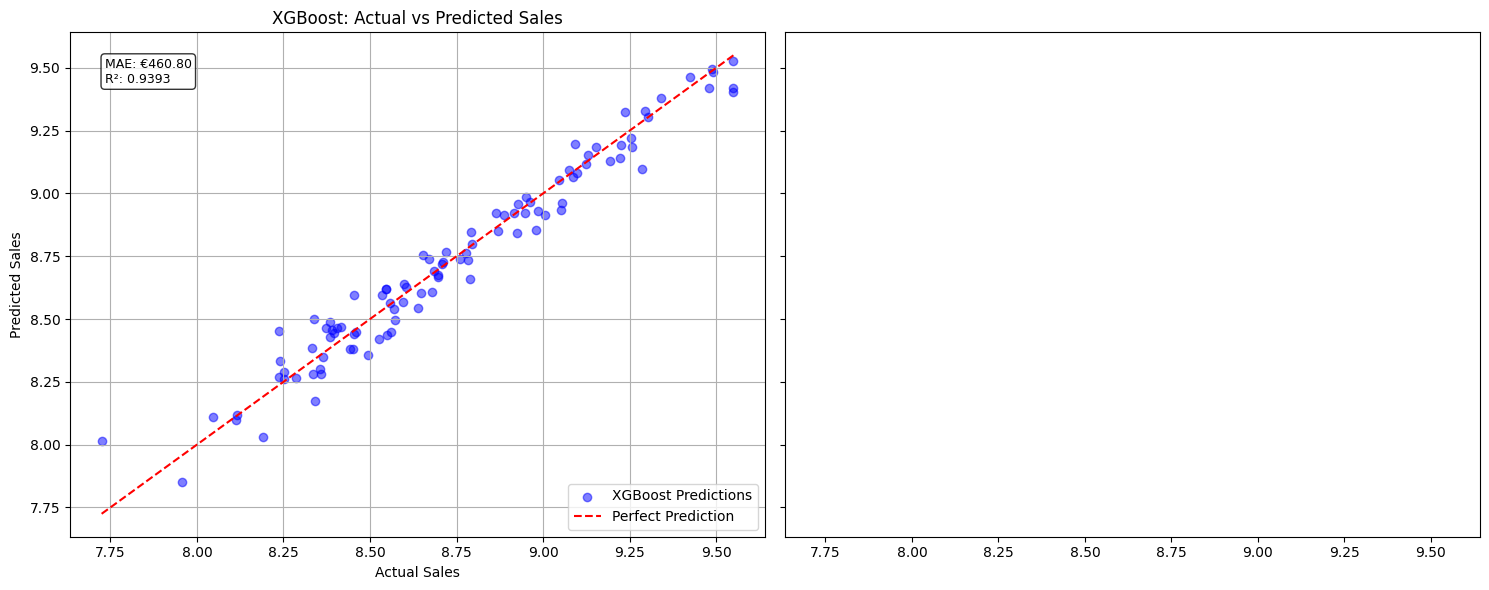

In [62]:
# Actual vs Predicted Sales
plt.figure(figsize=(15, 6))
sample_indices = np.random.choice(len(y_test), size=100, replace=False)
actual = y_test.iloc[sample_indices].values
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True, sharex=True)
colors = {'XGBoost': 'blue', 'Random Forest': 'green'}
for idx, (name, res) in enumerate(results.items()):
    predicted = res["predictions"][sample_indices]
    axes[idx].scatter(actual, predicted, alpha=0.5, color=colors[name], label=f'{name} Predictions')
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    axes[idx].set_title(f'{name}: Actual vs Predicted Sales')
    axes[idx].set_xlabel('Actual Sales')
    axes[idx].set_ylabel('Predicted Sales')
    axes[idx].grid(True)
    axes[idx].legend()
    axes[idx].text(0.05, 0.95, f'MAE: €{res["Test_MAE"]:.2f}\nR²: {res["Test_R2"]:.4f}',
                   transform=axes[idx].transAxes, fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

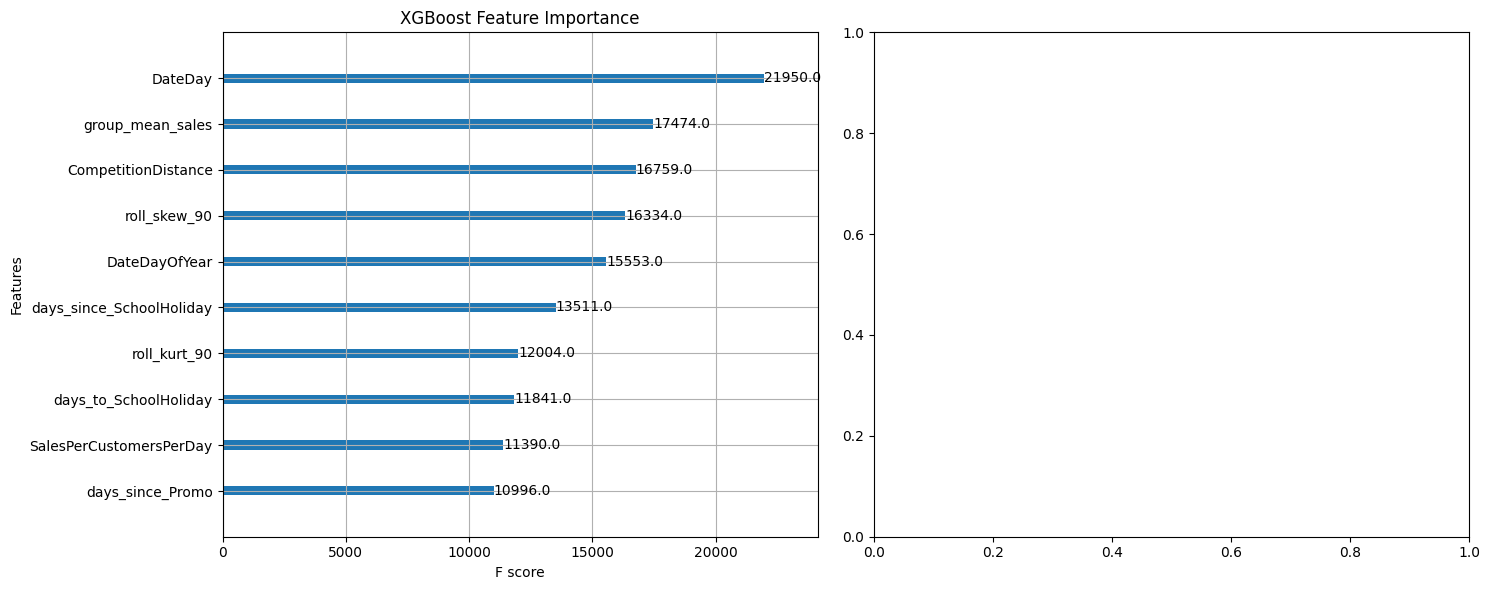

In [88]:
# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# XGBoost
xgb.plot_importance(results["XGBoost"]["model"], ax=axes[0], max_num_features=10)
axes[0].set_title('XGBoost Feature Importance')
# Random Forest
# sorted_idx = results["Random Forest"]["model"].feature_importances_.argsort()[-10:]
# axes[1].barh(feature_names[sorted_idx], results["Random Forest"]["model"].feature_importances_[sorted_idx], color='green')
# axes[1].set_title('Random Forest Feature Importance')
# axes[1].set_xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
feature_names[[4,0,17,1,7,3,21,10,26,25]]

Index(['days_since_Promo', 'CompetitionDistance', 'Promo', 'Store',
       'roll_kurt_365', 'roll_skew_365', 'roll_std_90', 'DateDay',
       'roll_mean_180', 'roll_std_365'],
      dtype='object')

Key Recommendations:

*   Adopt XGBoost for demand planning, staffing, and promotion scheduling.
*  Use weekly patterns/lag features to refine short-term strategies.
*  Schedule promotions mid-week, as weekends already drive organic sales.
*  Monitor local competition, even if correlations appear weak.













# Export data

In [278]:
X_submit = df.loc[df['Set'] == 0]
y_submit = best_model.predict(X_submit[features_x])

In [279]:
df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = np.expm1(y_submit)

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_best_no_ext_data_scaled.csv', index=False)